# Local spatial autocorrelation analysis for 2024 presidential election in Virginia

In [3]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles
from splot import esda as esdaplot

In [4]:
# The vote results are stored in a csv file which we read into a dataframe:
va_vote_data_path = "./2024_VA_County_Level_Presidential_Results.csv"
va_vote_df = pandas.read_csv(va_vote_data_path)


In [5]:
# Convert the county_fips code to a string
va_vote_df['county_fips'] = va_vote_df['county_fips'].astype("string")

In [6]:
# calculate the percentage of votes 
va_vote_df['per_gop'] = va_vote_df['per_gop']*100
va_vote_df['per_dem'] = va_vote_df['per_dem']*100
va_vote_df['per_point_diff'] = va_vote_df['per_point_diff']*100

In [7]:
# Read in the shapefile for Virginia counties
VA_Counties_gdf = geopandas.read_file(
    "./VA_Counties.json"
)

In [8]:
# Select only the columns we need
VA_Counties_gdf= VA_Counties_gdf[["US_Counties_20m_GEOID","geometry"]]

In [9]:
# Merge the two dataframes on the county_fips column
db = VA_Counties_gdf.merge(va_vote_df, left_on="US_Counties_20m_GEOID", right_on="county_fips", how="left")


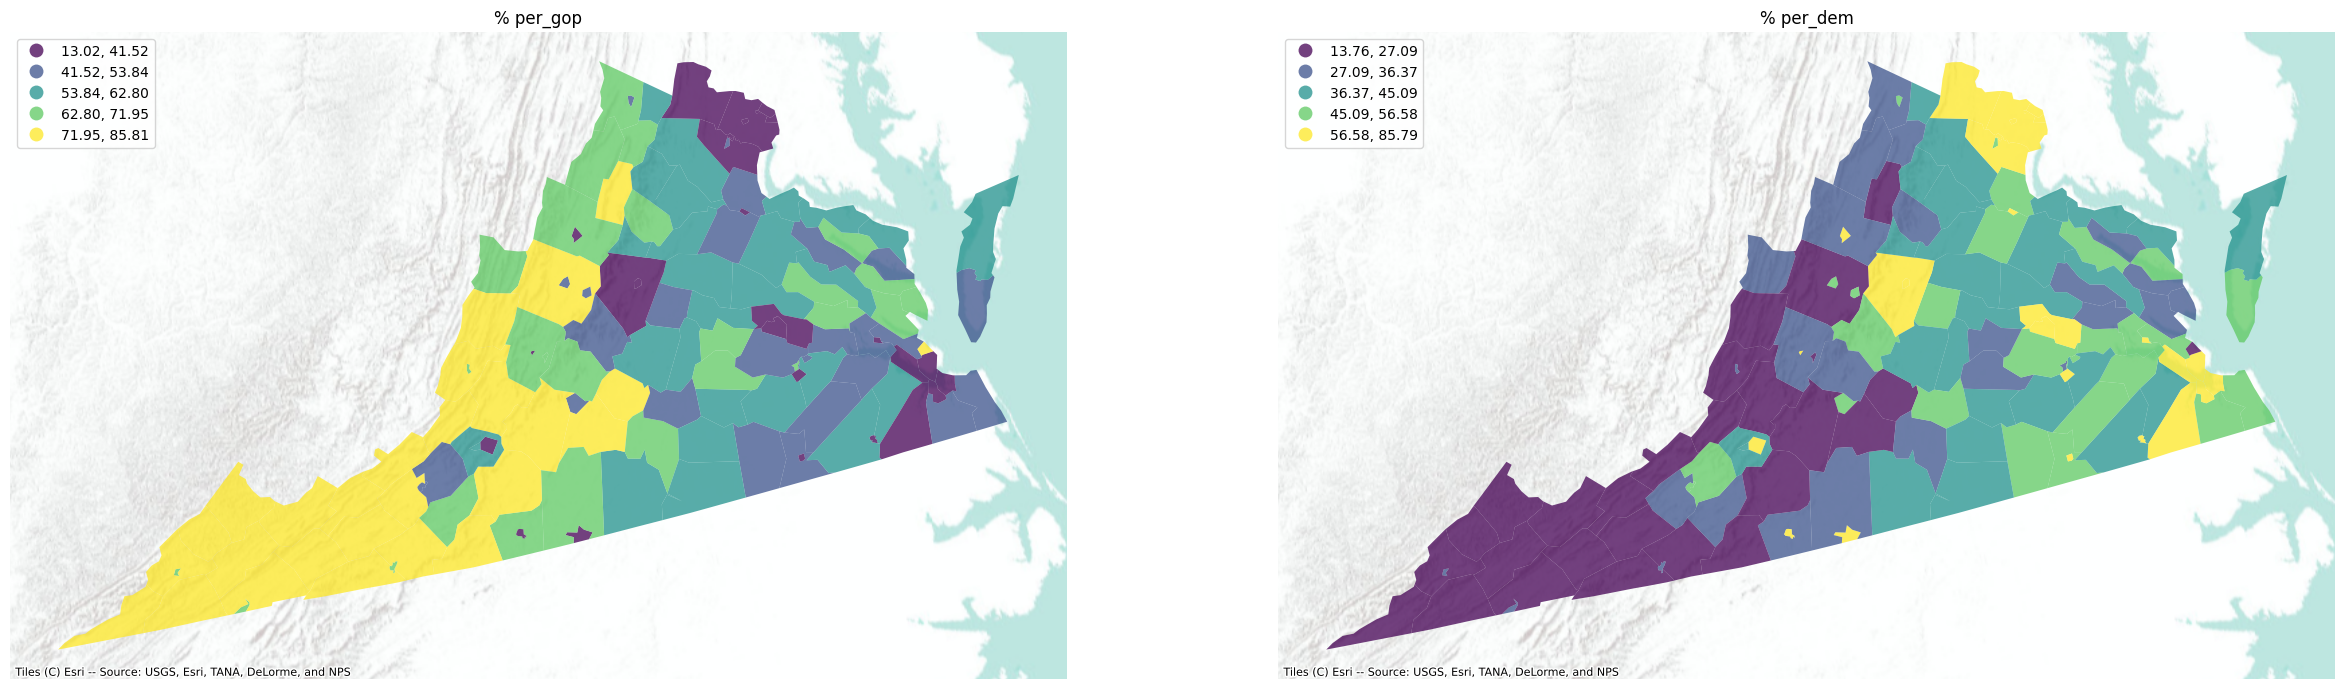

In [10]:
# Plotting the results of the per_gop and per_dem
f, axs = plt.subplots(1, 2,figsize=(30, 15))
ax1, ax2 = axs
db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax1,
)
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax1.set_title("% per_gop")
ax1.set_axis_off()

db.plot(
    column="per_dem",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax2,
)
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax2.set_title("% per_dem")
ax2.set_axis_off()

In [11]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

In [12]:
# Calculate the spatial lag
db["w_per_gop"] = weights.lag_spatial(w, db['per_gop'])
db["w_per_dem"] = weights.lag_spatial(w, db['per_dem'])

In [13]:
db["per_gop_std"] = db["per_gop"] - db["per_gop"].mean()
db["w_per_gop_std"] = weights.lag_spatial(w, db['per_gop_std'])

db["per_dem_std"] = db["per_dem"] - db["per_dem"].mean()
db["w_per_dem_std"] = weights.lag_spatial(w, db['per_dem_std'])

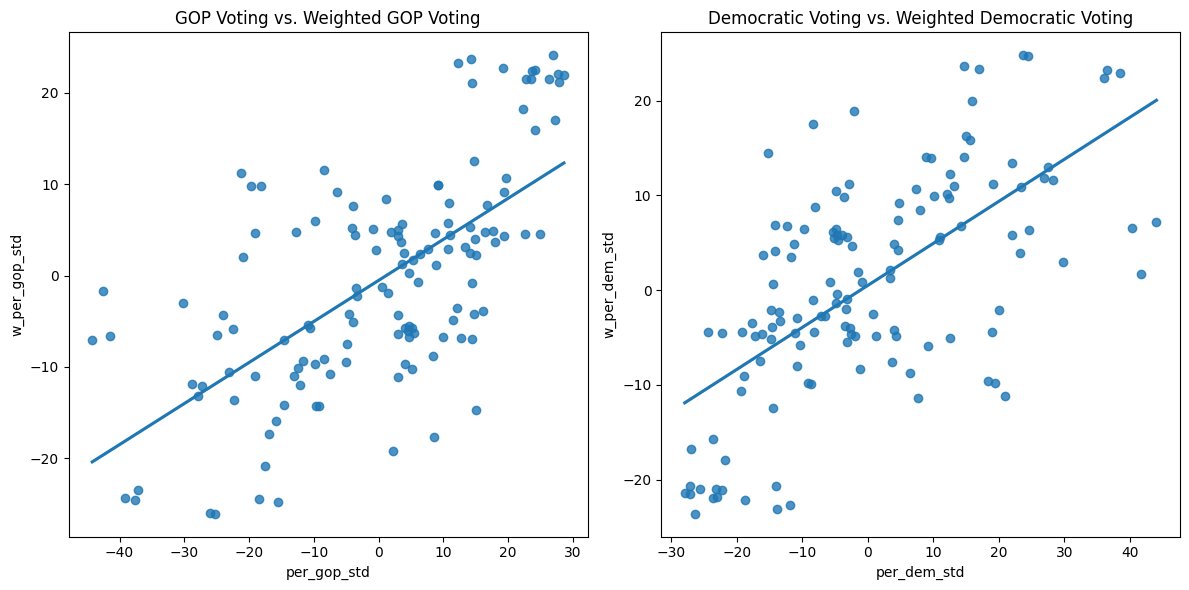

In [14]:


# Set up the figure with two subplots side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first regression line for GOP data
seaborn.regplot(
    x="per_gop_std", y="w_per_gop_std", data=db, ci=None, ax=ax1
)
ax1.set_title('GOP Voting vs. Weighted GOP Voting')

# Plot the second regression line for DEM data
seaborn.regplot(
    x="per_dem_std", y="w_per_dem_std", data=db, ci=None, ax=ax2
)
ax2.set_title('Democratic Voting vs. Weighted Democratic Voting')

# Display the plot
plt.tight_layout()
plt.show()


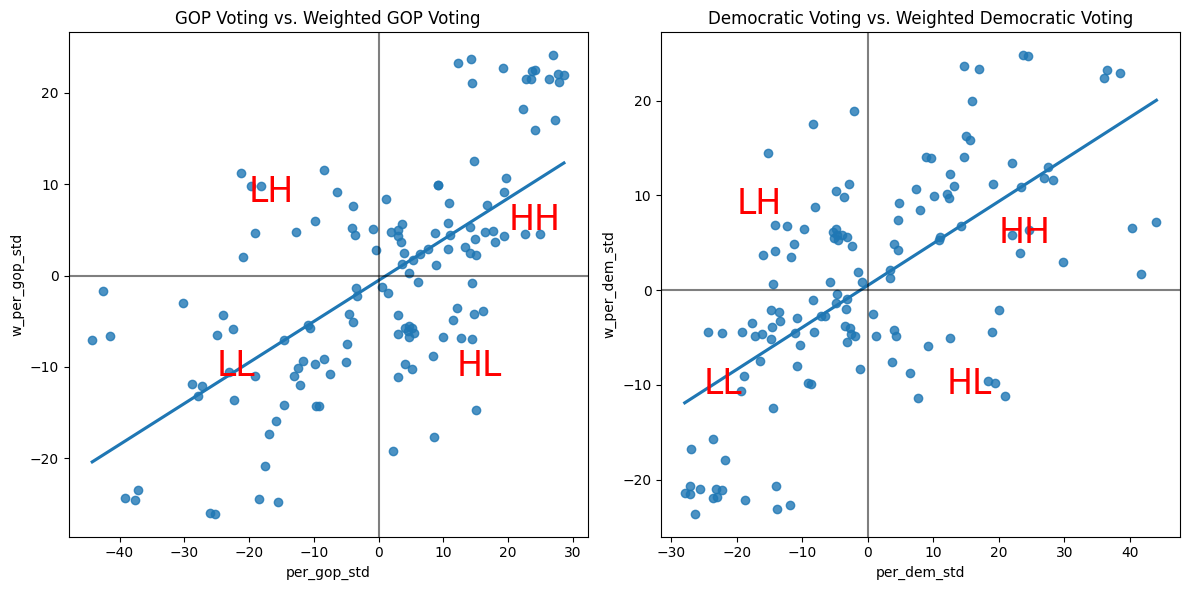

In [15]:

# Set up the figure with two subplots side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first regression line for GOP data on the first axis
seaborn.regplot(
    x="per_gop_std", y="w_per_gop_std", data=db, ci=None, ax=ax1
)
# Add vertical and horizontal lines
ax1.axvline(0, c="k", alpha=0.5)
ax1.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
ax1.text(20, 5, "HH", fontsize=25, c="r")
ax1.text(12, -11, "HL", fontsize=25, c="r")
ax1.text(-20, 8.0, "LH", fontsize=25, c="r")
ax1.text(-25, -11.0, "LL", fontsize=25, c="r")
ax1.set_title("GOP Voting vs. Weighted GOP Voting")

# Plot the second regression line for DEM data on the second axis
seaborn.regplot(
    x="per_dem_std", y="w_per_dem_std", data=db, ci=None, ax=ax2
)
# Add vertical and horizontal lines
ax2.axvline(0, c="k", alpha=0.5)
ax2.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
ax2.text(20, 5, "HH", fontsize=25, c="r")
ax2.text(12, -11, "HL", fontsize=25, c="r")
ax2.text(-20, 8.0, "LH", fontsize=25, c="r")
ax2.text(-25, -11.0, "LL", fontsize=25, c="r")
ax2.set_title("Democratic Voting vs. Weighted Democratic Voting")

# Display the plot
plt.tight_layout()
plt.show()


In [16]:
lisa_gop = esda.moran.Moran_Local(db["per_gop"], w)
lisa_dem = esda.moran.Moran_Local(db["per_dem"], w)

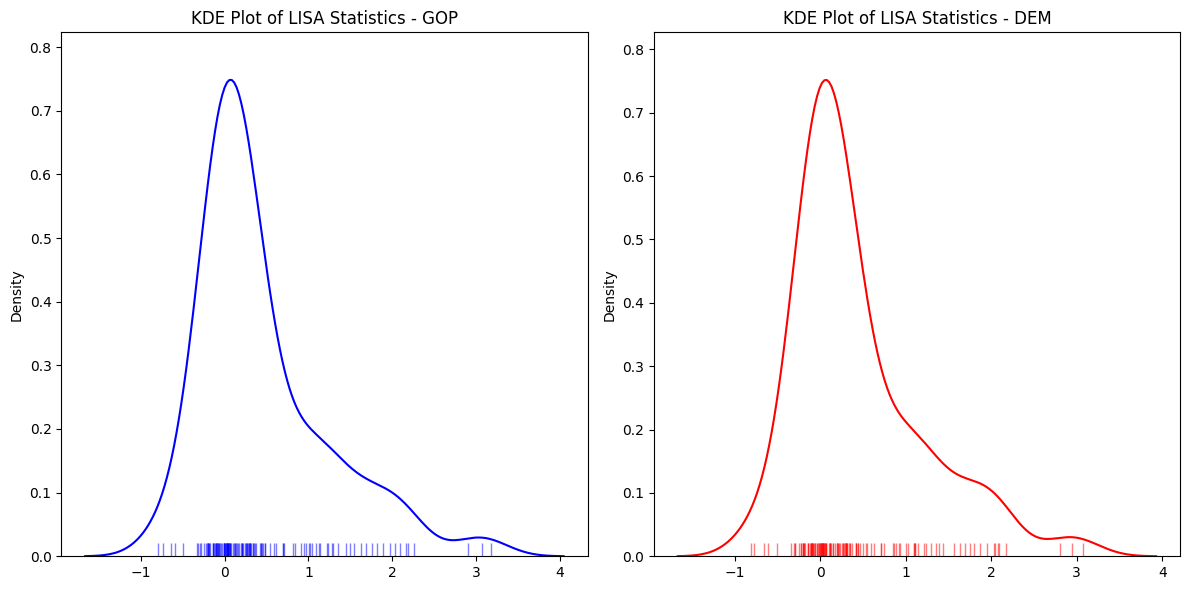

In [17]:

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot KDE and rug for GOP on the first subplot
seaborn.kdeplot(lisa_gop.Is, ax=axes[0], color="blue")
seaborn.rugplot(lisa_gop.Is, ax=axes[0], color="blue", alpha=0.5)
axes[0].set_title("KDE Plot of LISA Statistics - GOP")

# Plot KDE and rug for DEM on the second subplot
seaborn.kdeplot(lisa_dem.Is, ax=axes[1], color="red")
seaborn.rugplot(lisa_dem.Is, ax=axes[1], color="red", alpha=0.5)
axes[1].set_title("KDE Plot of LISA Statistics - DEM")

# Adjust layout and display
plt.tight_layout()
plt.show()


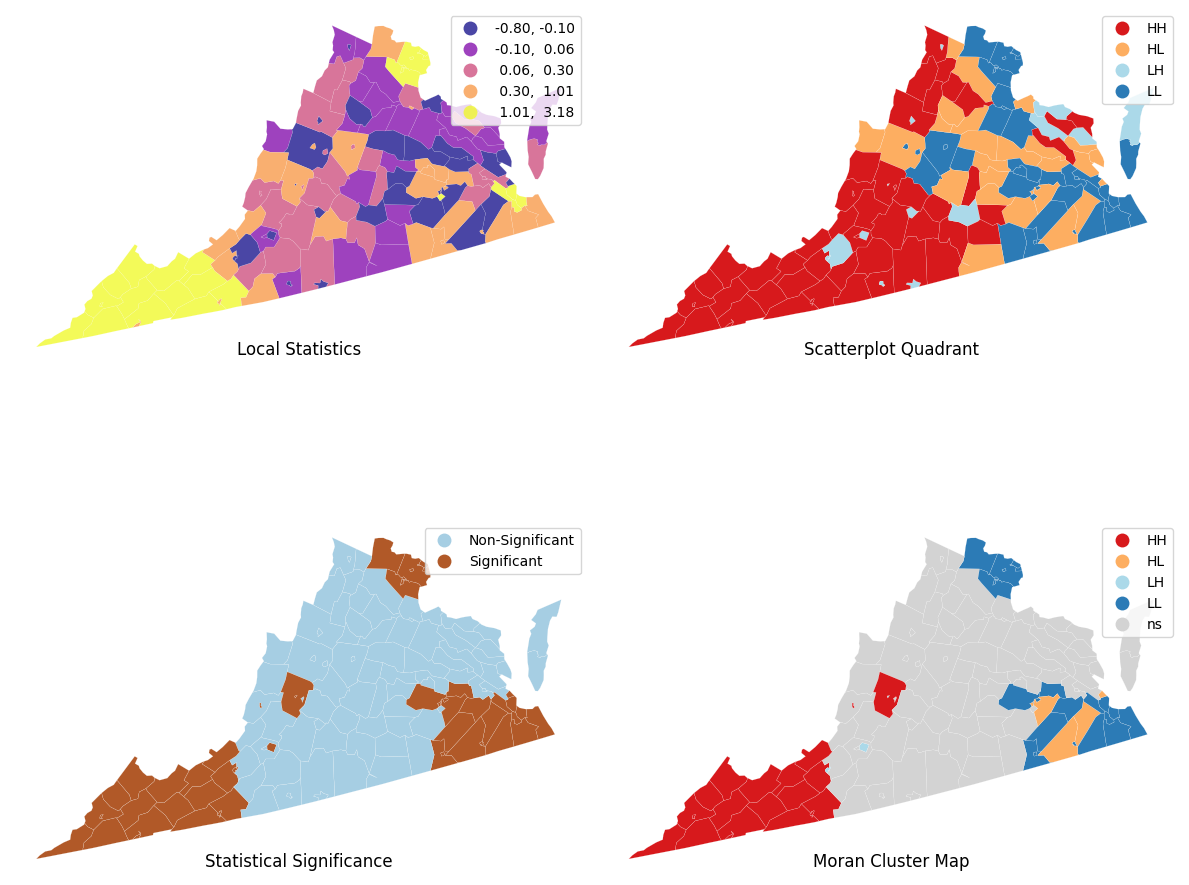

In [19]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa_gop.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_gop, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa_gop.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_gop, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

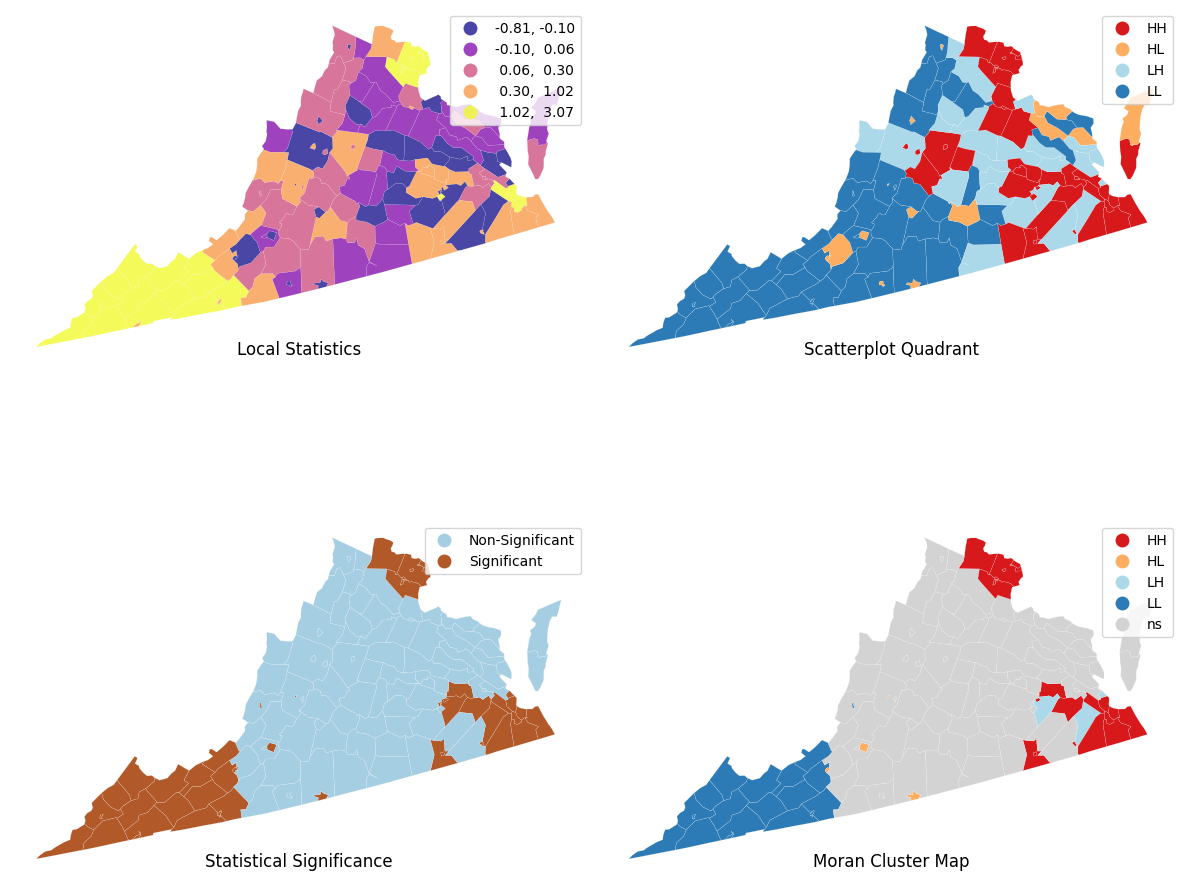

In [20]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa_dem.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_dem, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa_dem.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_dem, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()